https://github.com/NurNils/opencv-lane-detection

이 코드를 기반으로 만듦

In [1]:
# Imports
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import time
import warnings
# Dont show warnings
warnings.filterwarnings("ignore")

# number of windows for sliding windows 
nwindows = 180

# value for last radius
last_r = None

# For radius calculation (pixels to meters)
y_m_per_pix = 30 / 720
x_m_per_pix = 3.7 / 1280

# Source and destination for perspective transformation
src = np.array([[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Kernels for filter operations
kernel_small = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'uint8')
kernel_large = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], 'uint8')

# ROI (trapezoid)
#ROI = np.array([[(570, 450),(650, 450),(1300, 650),(200, 650)]], dtype= np.int32)

In [2]:
# Convert image to yellow and white color space
def color_space(img):
    # Convert image to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # Colorspace "yellow" in HSV: (15-40, 80-255, 160-255)
    mask_yellow = cv.inRange(img_hsv, (15, 100, 160), (40, 255, 255))
    # Colorspace "white" in HSV: (0-255, 0-20, 200-255)
    mask_white = cv.inRange(img_hsv, (0, 0, 200), (255, 70, 255))
    # Merge white and yellow masks
    masks = cv.bitwise_or(mask_yellow, mask_white)
    # Return image in gray
    
    return cv.cvtColor(cv.bitwise_and(img, img, mask=masks), cv.COLOR_BGR2GRAY)

# Apply canny filter to image
def canny_space(img, lower=80, upper=200):
    # Equalize histogramm with gray image
    equalized_gray_image = cv.equalizeHist(img)
    # Blur image three times
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    # Return image with canny filter
    return cv.Canny(equalized_gray_image, lower, upper) 

# Dilate image (Expands the shapes of the image)
def dilate(img, iterations):
    return cv.dilate(img, kernel_small, iterations=iterations)

# Erode image (Reduces the shapes of the image)
def erode(img, iterations):
    return cv.erode(img, kernel_small, iterations=iterations)

# Close image (Removes noises)
def close(img, iterations):
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel_large, iterations=iterations)

In [28]:
import cv2
import numpy as np

def sliding_windows_visual(warped_img, nwindows=9, margin=200, minimum=30, draw=True):
    # ▶ ROI 마스킹: 잘못된 영역 제거
    mask = np.ones_like(warped_img, dtype=np.uint8) * 255
    height, width = warped_img.shape
    cv2.rectangle(mask, (0, height - 0), (600, height), 0, -1)
    warped_img = cv2.bitwise_and(warped_img, mask)

    # ▶ 모폴로지 연산으로 노이즈 제거
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    warped_img = cv2.morphologyEx(warped_img, cv2.MORPH_OPEN, kernel)

    # ▶ 시각화용 이미지 생성
    out_img = np.dstack((warped_img, warped_img, warped_img)) * 255

    # ▶ 히스토그램 기반 시작점 계산
    histogram = np.sum(warped_img[warped_img.shape[0]//2:, :], axis=0)
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # ▶ 슬라이딩 윈도우 초기화
    window_height = warped_img.shape[0] // nwindows
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = warped_img.shape[0] - (window + 1) * window_height
        win_y_high = warped_img.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if draw:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,255), 2)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minimum:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minimum:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # ▶ 이상점 제거
    left_fit, right_fit = None, None
    if len(leftx) > 20:
        left_fit = np.polyfit(lefty, leftx, 2)
        residuals = np.abs(np.polyval(left_fit, lefty) - leftx)
        mask = residuals < 30
        leftx = leftx[mask]
        lefty = lefty[mask]
    if len(rightx) > 20:
        right_fit = np.polyfit(righty, rightx, 2)
        residuals = np.abs(np.polyval(right_fit, righty) - rightx)
        mask = residuals < 30
        rightx = rightx[mask]
        righty = righty[mask]

    # ▶ 픽셀 색상 표시
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # ▶ 보간 곡선 시각화
    if draw:
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        if left_fit is not None:
            left_fitx = np.polyval(left_fit, ploty)
            for i in range(len(ploty)-1):
                cv2.line(out_img, (int(left_fitx[i]), int(ploty[i])), (int(left_fitx[i+1]), int(ploty[i+1])), (255, 255, 0), 2)
        if right_fit is not None:
            right_fitx = np.polyval(right_fit, ploty)
            for i in range(len(ploty)-1):
                cv2.line(out_img, (int(right_fitx[i]), int(ploty[i])), (int(right_fitx[i+1]), int(ploty[i+1])), (0, 255, 255), 2)

    return {
        "image": out_img,
        "left": {
            "fit": left_fit,
            "x": leftx,
            "y": lefty,
        },
        "right": {
            "fit": right_fit,
            "x": rightx,
            "y": righty,
        }
    }


In [4]:
# Warp image perspective
def warp(img, src=src, dst=dst):
    M = cv.getPerspectiveTransform(src, dst)
    return cv.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv.INTER_NEAREST)

# Crop image for region of interest
def crop(img, ROI):
    # Create blank img with same size as input img
    blank = np.zeros(img.shape[:2], np.uint8)

    # Fill region of interest
    region_of_interest = cv.fillPoly(blank, ROI, 255)

    # Create image of interest with region (resize)
    return cv.bitwise_and(img, img, mask=region_of_interest)

# Merge to masks
def merge(frame, img1, img2):
    both = frame.copy()
    both[np.where(np.logical_and(img1==0, img2==0))] = 0
    return both

# Overlay two images
def overlay(img, overlay):
    img[np.where(overlay!=0)] = [0,255,0]
    return img

# Overlay two images with alpha
def overlay_alpha(img, overlay):
    return cv.addWeighted(img, 1, overlay.astype(np.uint8), 0.5, 0.0)

선이 직선인지 대쉬선인지 확인

현재 선간의 빈 공간 개수로 판정하는ㄱ데 선 간의 거리 등을 통해 보정을 해 줘야 할 것으로 보임

In [ ]:
def detect_dash_line_along_curve(binary_img, fit, ploty, threshold_gap=50, threshold_segment=50):
    """
    다항 곡선을 따라 점선인지 실선인지 분석.
    - binary_img: 흑백 이미지 (차선만 흰색)
    - fit: np.polyfit으로 얻은 다항 계수
    - ploty: y좌표 배열
    - threshold_gap: 점선 판단 기준이 되는 최소 gap
    - threshold_segment: 실선 판단 기준이 되는 최소 선의 길이
    """
    gaps = []
    segments = []
    last_seen = None
    current_segment = 0
    
    for i, y in enumerate(ploty.astype(int)):
        x = int(np.polyval(fit, y))
        if 0 <= y < binary_img.shape[0] and 0 <= x < binary_img.shape[1]:
            radius = 20
            if np.any(binary_img[y, max(x - radius, 0): min(x + radius + 1, binary_img.shape[1])] > 0) or i == len(ploty) - 1:
                if last_seen is not None:
                    gap = y - last_seen
                    if gap > threshold_gap:
                        gaps.append(gap)
                        if current_segment > 20:
                            segments.append(current_segment)
                        current_segment = 0
                    else:
                        current_segment += gap
                last_seen = y

    if current_segment > 0:
        segments.append(current_segment)

    # 디버깅 출력
    
    print("평균 gap:", np.mean(gaps) if gaps else 0)
    print("gap 표준편차:", np.std(gaps) if gaps else 0)
    print("gap 개수:", len(gaps))
    print("평균 segment 길이:", np.mean(segments) if segments else 0)
    print("segment 개수:", len(segments))

    # 판단 조건
    if len(gaps) > 2 and np.mean(gaps) > threshold_gap and len(segments) >= 2:
        return "dashed"
    else:
        return "solid"


#결과인 다항식을 바탕으로 선을 시각화
def draw_lane_curve(binary_img, fit, ploty, line_type):
    color = (0, 255, 0) if line_type == "solid" else (0, 0, 255)
    curve_img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)
    x_vals = np.polyval(fit, ploty).astype(np.int32)
    for i in range(len(ploty)-1):
        pt1 = (x_vals[i], int(ploty[i]))
        pt2 = (x_vals[i+1], int(ploty[i+1]))
        if 0 <= pt1[0] < binary_img.shape[1] and 0 <= pt2[0] < binary_img.shape[1]:
            cv2.line(curve_img, pt1, pt2, color, 3)
    return curve_img

선 사이의 간격에 점으로 표시

코드에는 필요없으나 바로 위의 detect_dash_line_along_curve가 검출한 선 사이의 빈 공간을 시각적으로 표시하기 위해 사용

In [37]:
def draw_gap_markers(binary_img, fit, ploty, threshold_gap=50):
    """
    점선 간격(gap)을 시각적으로 표시.
    - binary_img: 차선이 흰색(255)인 이진 이미지
    - fit: np.polyfit 계수
    - ploty: y좌표 배열
    - threshold_gap: 간격 기준값
    """
    output = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)  # 컬러로 변환
    last_seen = None

    for i, y in enumerate(ploty.astype(int)):
        x = int(np.polyval(fit, y))
        if 0 <= y < binary_img.shape[0] and 0 <= x < binary_img.shape[1]:
            radius = 20  # x축으로 좌우 3픽셀 확인 (총 7픽셀 폭)
            if np.any(binary_img[y, max(x - radius, 0): min(x + radius + 1, binary_img.shape[1])] > 0) or i == len(ploty.astype(int)) - 1:
                if last_seen is not None:
                    gap = y - last_seen
                    if gap > threshold_gap:
                        #pass
                        # gap 위치를 초록색 점으로 표시
                        mid_y = (y + last_seen) // 2
                        mid_x = int(np.polyval(fit, mid_y))
                        cv2.circle(output, (mid_x, mid_y), 5, (0, 255, 0), -1)
                        if 0 <= mid_y < binary_img.shape[0] and 0 <= mid_x < binary_img.shape[1]:
                            cv2.circle(output, (mid_x, mid_y), 5, (0, 255, 0), -1)
                last_seen = y
    return output

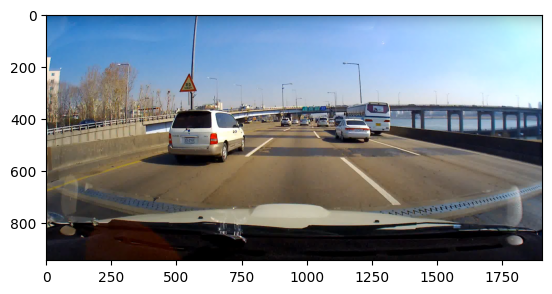

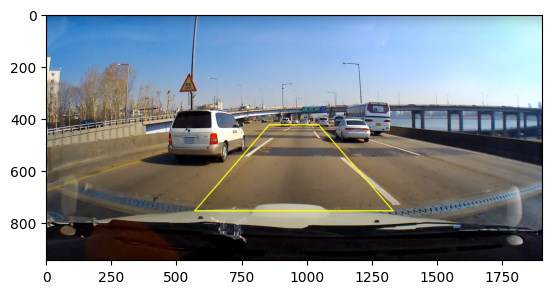

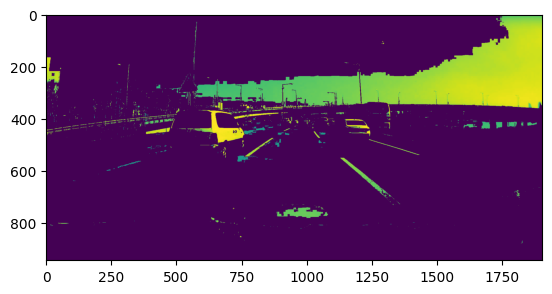

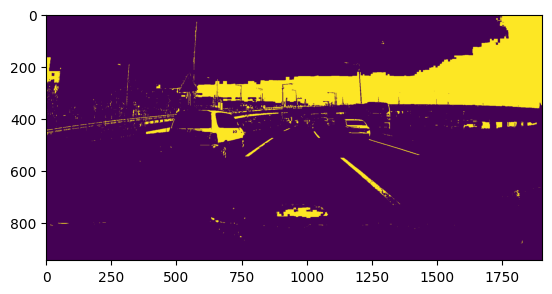

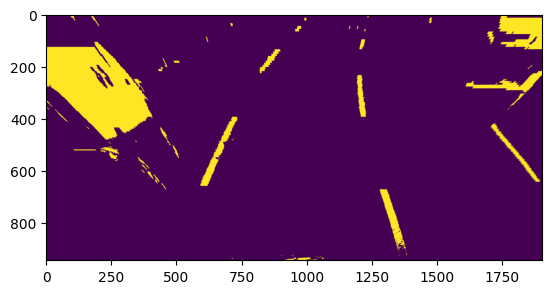

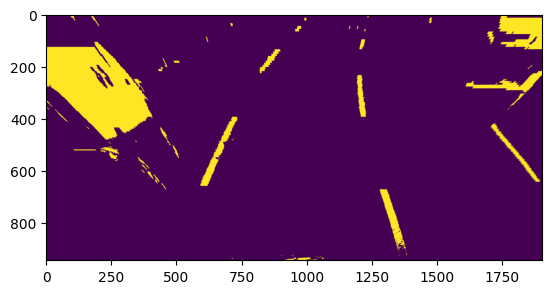

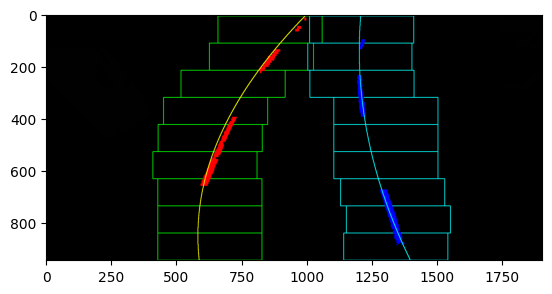

118.4
5
왼쪽 차선은 dashed


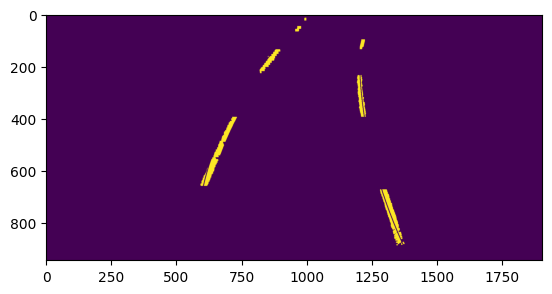

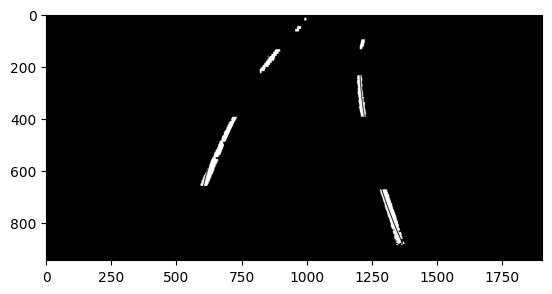

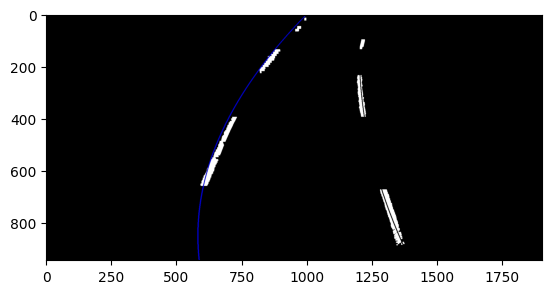

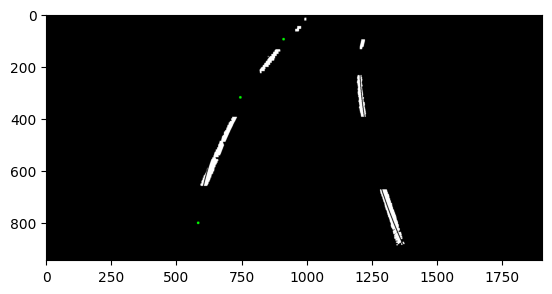

In [7]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

#img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.45],
    [width * 0.55, height * 0.45],
    [width * 0.7, height * 0.8],
    [width * 0.3, height * 0.8]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty, threshold_gap=10)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty, threshold_gap=50)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

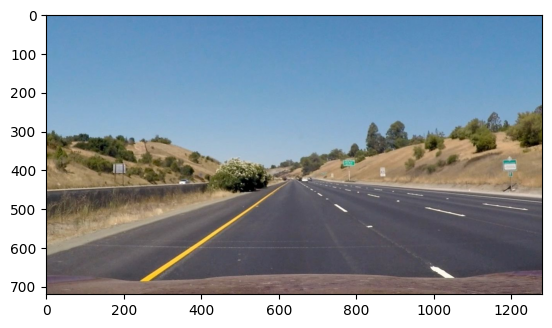

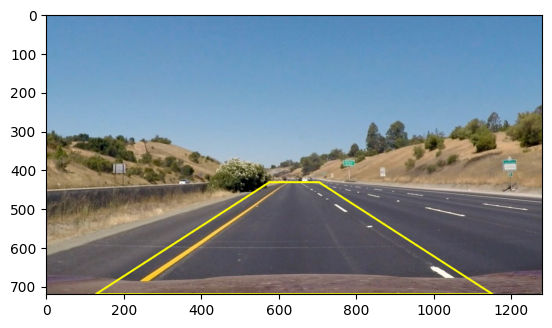

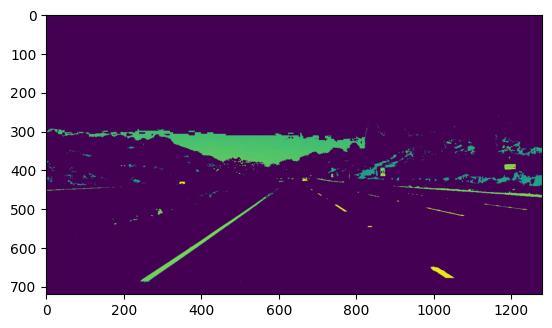

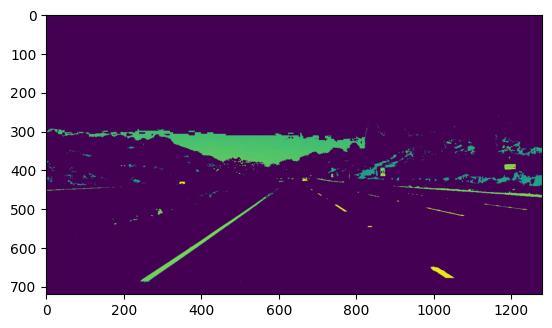

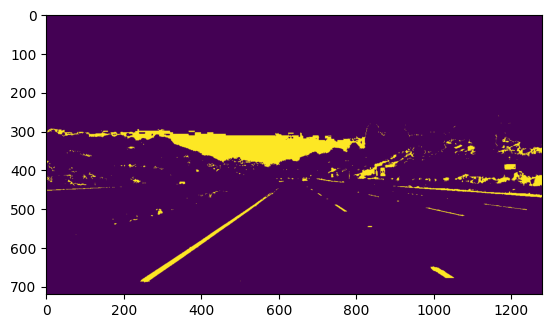

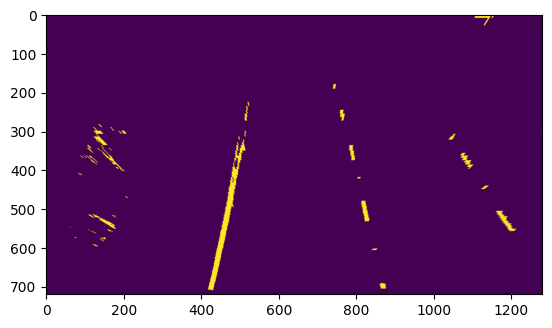

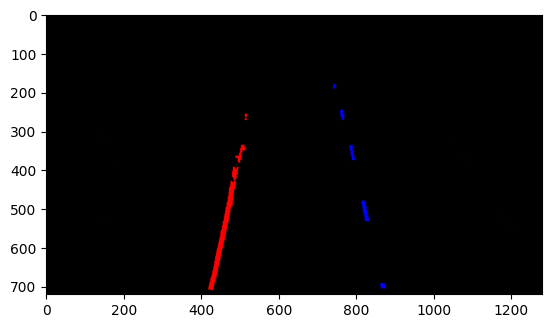

64.0
1
왼쪽 차선은 solid


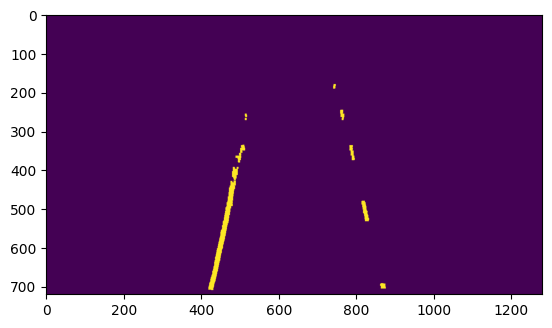

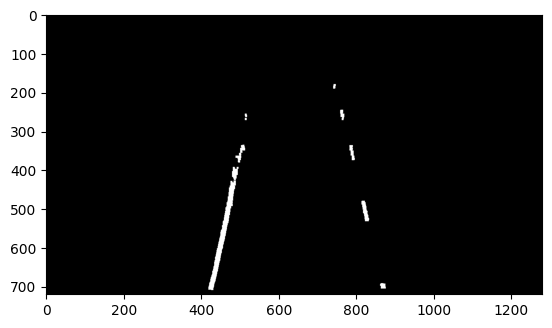

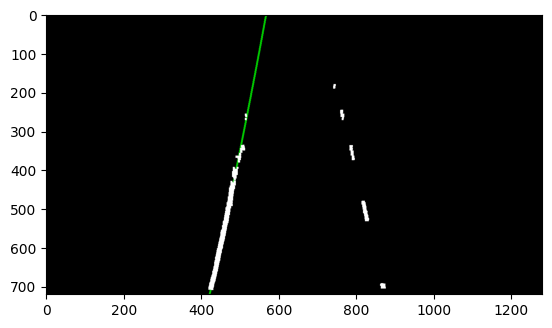

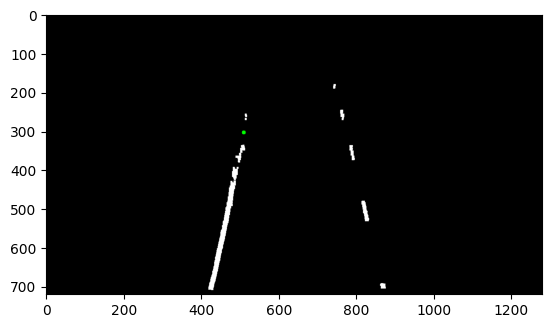

In [10]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.6],
    [width * 0.55, height * 0.6],
    [width * 0.9, height],
    [width * 0.1, height]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)

plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 100, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()



# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=False)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty, threshold_gap=50)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty, threshold_gap = 50)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

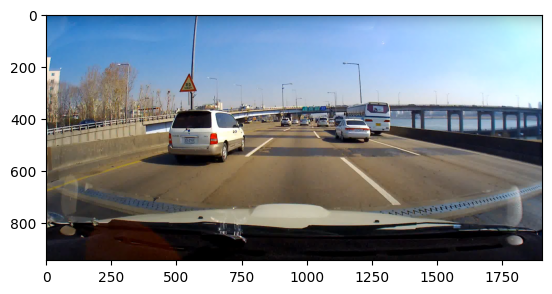

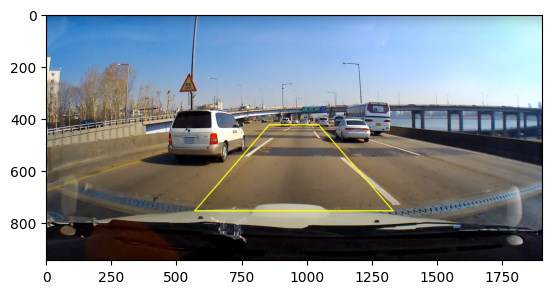

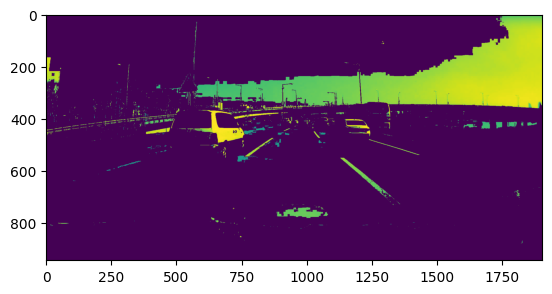

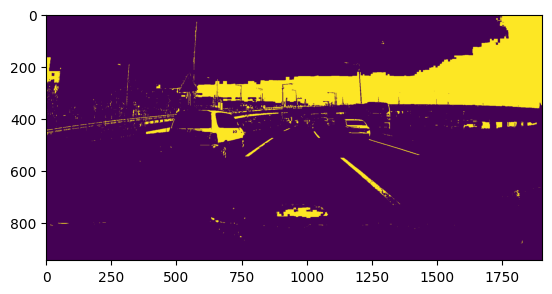

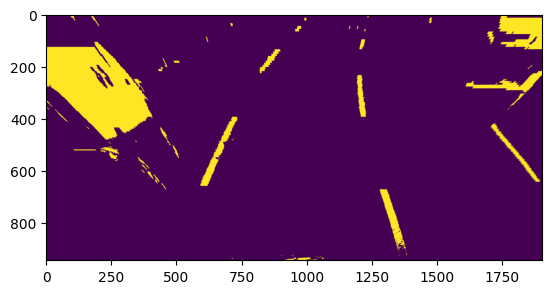

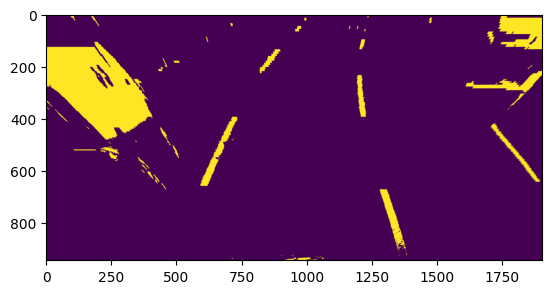

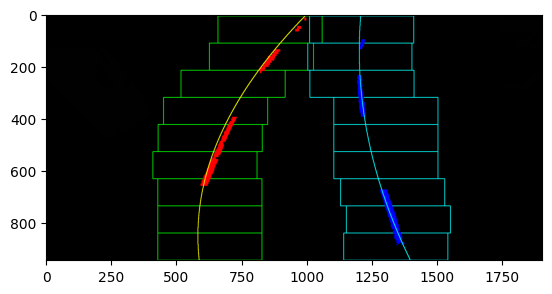

평균 gap: 173.66666666666666
gap 표준편차: 87.86479512422608
gap 개수: 3
평균 segment 길이: 135.66666666666666
segment 개수: 3
왼쪽 차선은 dashed


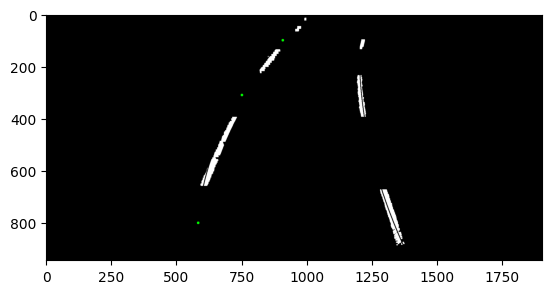

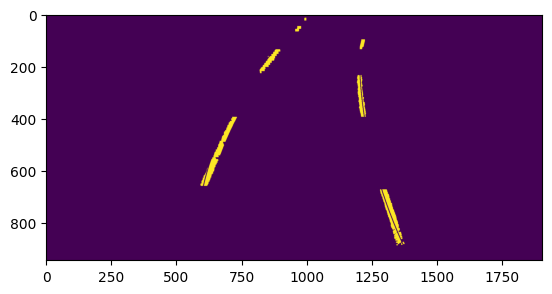

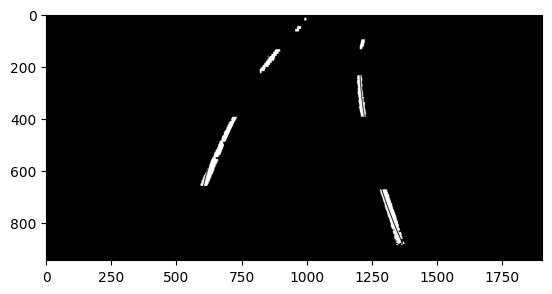

평균 gap: 145.66666666666666
gap 표준편차: 95.82739112012227
gap 개수: 3
평균 segment 길이: 136.0
segment 개수: 3
오른쪽 차선은 dashed


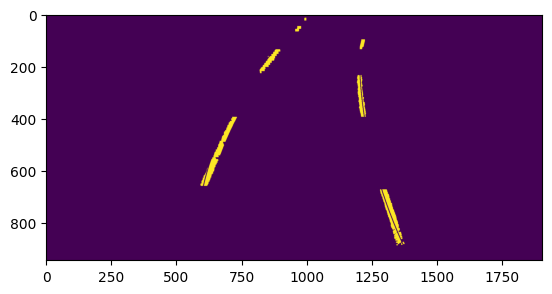

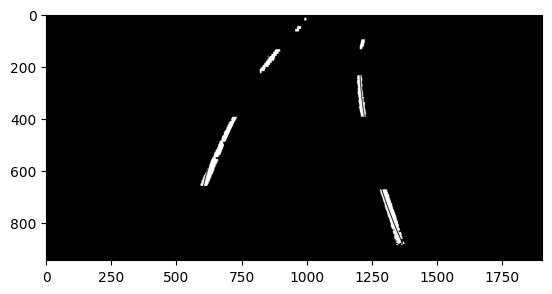

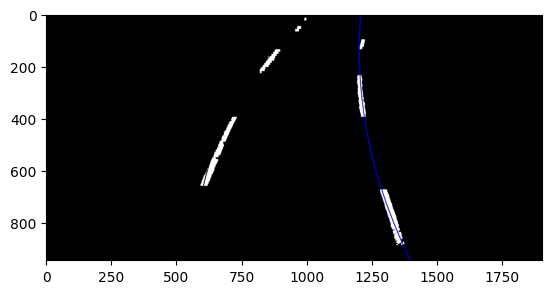

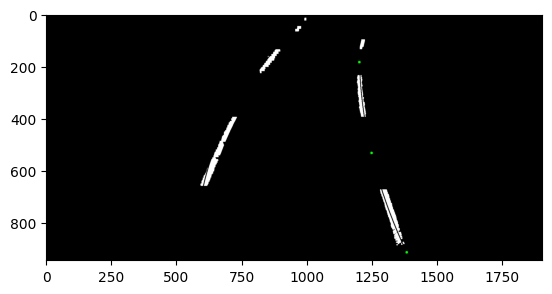

In [49]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

#img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.45],
    [width * 0.55, height * 0.45],
    [width * 0.7, height * 0.8],
    [width * 0.3, height * 0.8]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"오른쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["right"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object

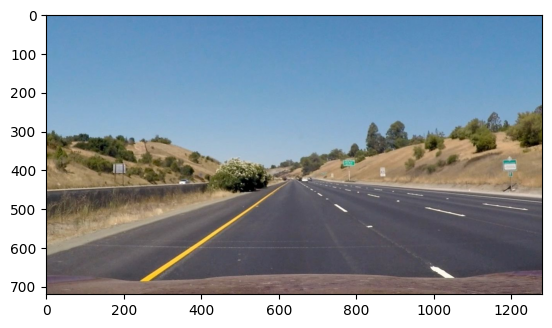

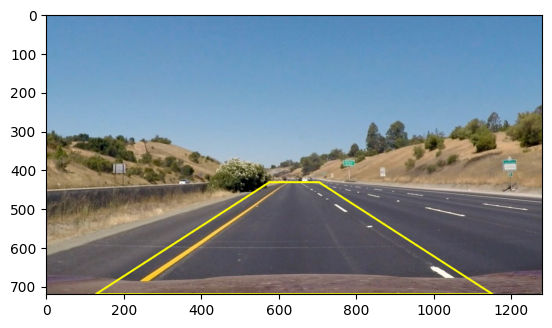

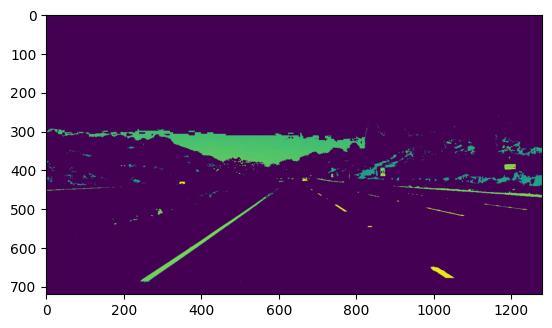

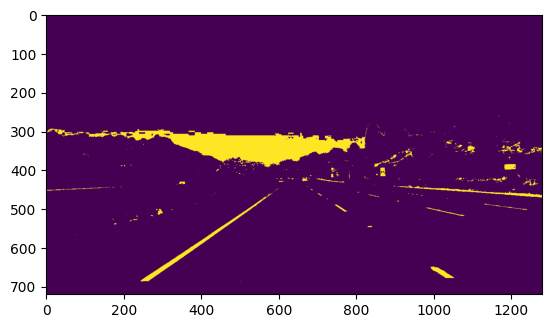

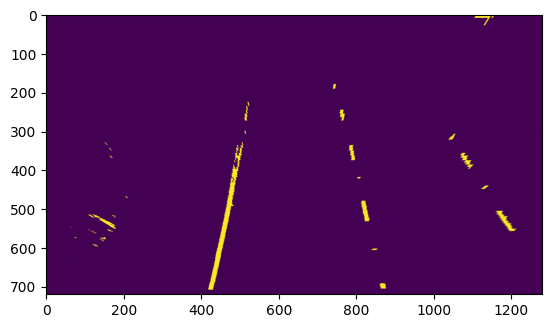

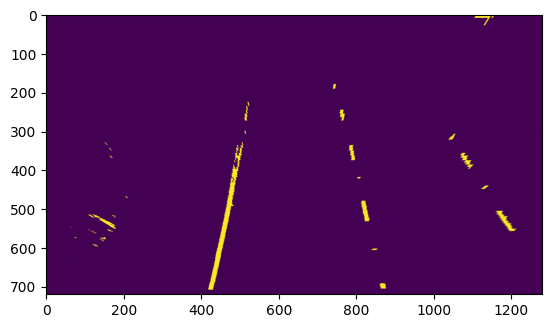

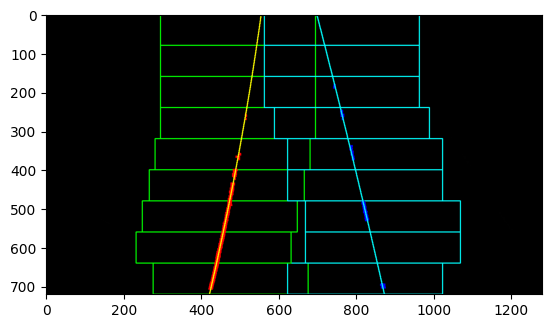

평균 gap: 85.0
gap 표준편차: 0.0
gap 개수: 1
평균 segment 길이: 189.0
segment 개수: 2
왼쪽 차선은 solid


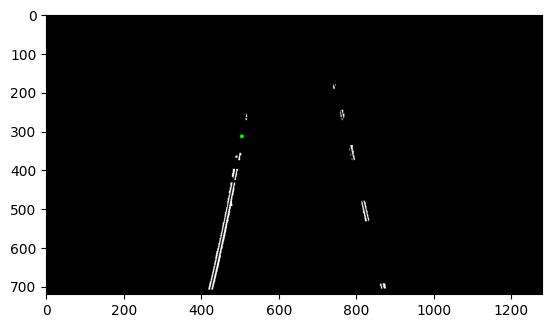

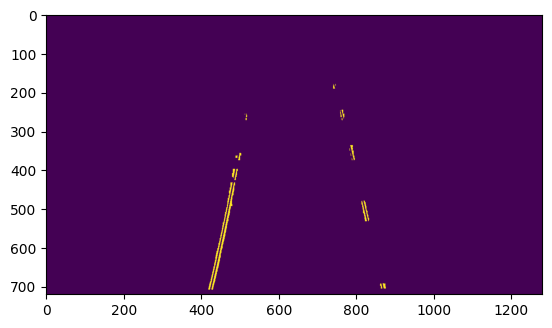

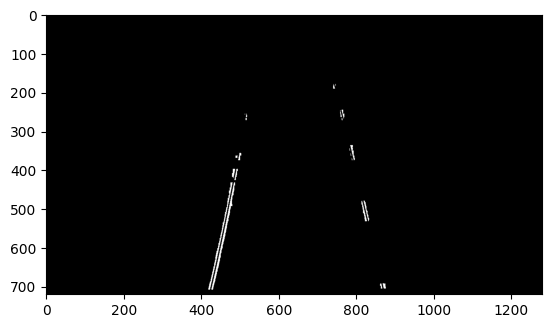

평균 gap: 96.25
gap 표준편차: 41.287861412284364
gap 개수: 4
평균 segment 길이: 30.8
segment 개수: 5
오른쪽 차선은 dashed


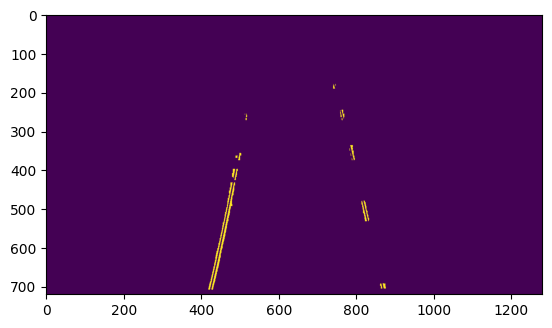

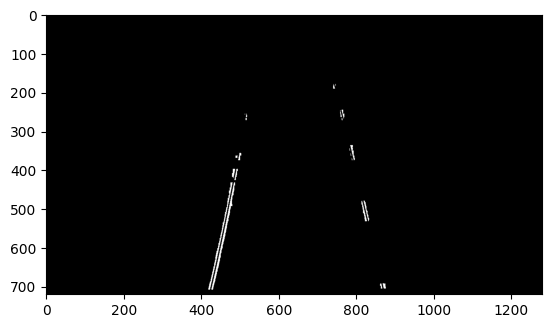

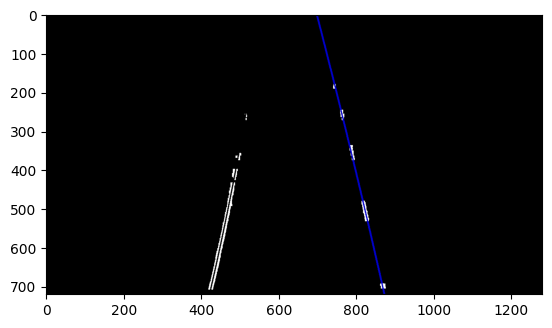

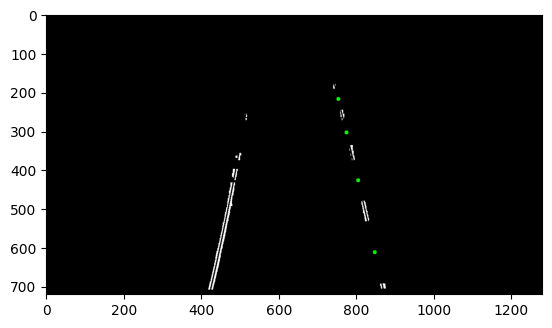

In [48]:
# Open video file
import matplotlib.pyplot as plt




def draw_polygon(img, points):
    overlay = img.copy()
    cv2.polylines(overlay, [np.int32(points)], isClosed=True, color=(0,255,255), thickness=3)
    return overlay



video_file = 'project'
img = cv.imread('img73.png')

img = cv.imread('lane.jpg')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
height, width = img.shape[:2]
src = np.float32([
    [width * 0.45, height * 0.6],
    [width * 0.55, height * 0.6],
    [width * 0.9, height],
    [width * 0.1, height]
])
dst = np.float32([
    [width * 0.3, 0],
    [width * 0.7, 0],
    [width * 0.7, height],
    [width * 0.3, height]
])

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
frame = img

# Check if there is another frame
orig = frame.copy()

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.show()

# Calculate curve area only every fifth frame for performance reasons
# Step 1: Warp image

# 확인
plt.imshow(cv2.cvtColor(draw_polygon(frame.copy(), src), cv2.COLOR_BGR2RGB))

plt.show()


# 흰색 범위 (value가 높고 saturation이 낮음)
white_lower = np.array([0, 0, 200])
white_upper = np.array([255, 100, 255])

# 노란색 범위
yellow_lower = np.array([15, 100, 200])
yellow_upper = np.array([35, 255, 255])


hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

white_mask = cv2.inRange(hsv, white_lower, white_upper)
yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)

lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

h, s, v = cv2.split(hsv)
#v = cv2.add(v, -100)  # 밝기 증가 (0~255 클램핑됨)
s = cv2.add(s, -50)  # 밝기 증가 (0~255 클램핑됨)
final_hsv = cv2.merge((h, s, v))

masked = cv2.bitwise_and(img, img, mask=lane_mask)

color = color_space(frame)
plt.imshow(color)
plt.show()
#color = close(color, 10)
_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

color = warp(binary_result, src, dst)


# Step 2: Apply color mask and close image for get rid of small distrubances
plt.imshow(color)
plt.show()

_, binary_result = cv.threshold(color, 150, 255, cv.THRESH_BINARY)
plt.imshow(binary_result)
plt.show()

# Step 3: Sliding windows to get curve points    
#midpoint, lefts, rights = sliding_windows(color)


result = sliding_windows_visual(color, minimum =100, draw=True)


plt.imshow(result["image"])

plt.show()

# Step 4: Calculate curve and radius
#left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

lower_red = np.array([0, 0, 200])
upper_red = np.array([50, 50, 255])
mask_red = cv2.inRange(result["image"], lower_red, upper_red)

# 파란색 마스크
lower_blue = np.array([200, 0, 0])
upper_blue = np.array([255, 50, 50])
mask_blue = cv2.inRange(result["image"], lower_blue, upper_blue)

# 두 마스크 합치기
mask_combined = cv2.bitwise_or(mask_red, mask_blue)

# 마스크 결과를 흑백 형태로 출력 (255: 흰색, 나머지: 검정)
output = cv2.cvtColor(mask_combined, cv2.COLOR_GRAY2BGR)  # 필요 시 RGB 이미지로 변환


ploty = np.linspace(0, result["image"].shape[0] - 1, num=result["image"].shape[0])
line_type = detect_dash_line_along_curve(mask_combined, result["left"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["left"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"왼쪽 차선은 {line_type}")

gap_draw = draw_gap_markers(mask_combined, result["left"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

line_type = detect_dash_line_along_curve(mask_combined, result["right"]["fit"], ploty)

left_lane_img = draw_lane_curve(mask_combined, result["right"]["fit"], ploty, line_type)

overlay = cv2.addWeighted(output, 1.0, left_lane_img, 0.8, 0)

print(f"오른쪽 차선은 {line_type}")

plt.imshow(mask_combined)

plt.show()
plt.imshow(output)
plt.show()

plt.imshow(overlay)
plt.show()

gap_draw = draw_gap_markers(mask_combined, result["right"]["fit"], ploty)
plt.imshow(gap_draw)
plt.show()
# When everything done, release the video capture object